In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join(base_dir, 'train5k_5cat')
test_dir = os.path.join( base_dir,'test1k_5cat')


In [3]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
train_2 = os.path.join(train_dir, '2') 
train_3 = os.path.join(train_dir, '3')  
train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
val_2 = os.path.join(val_dir, '2') 
val_3 = os.path.join(val_dir, '3')  
val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
num_2_tr = len(os.listdir(train_2))
num_3_tr = len(os.listdir(train_3))
num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
num_2_v = len(os.listdir(val_2))
num_3_v = len(os.listdir(val_3))
num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr + num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v + num_2_v + num_3_v + num_4_v
 

In [4]:

def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float32)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float32)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

def augment_pre(image):
    
    augmentation=True
    
    BRIGHTNESS_MAX_DELTA = 0.125
    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5
    HUE_MAX_DELTA = 0.2
    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    image = rescale_min_1_to_1(image)

    # Apply data augmentations randomly.
    augmentations = [
        {'fn': tf.image.random_flip_left_right},
        {'fn': tf.image.random_brightness,
         'args': [BRIGHTNESS_MAX_DELTA]},
        {'fn': tf.image.random_saturation,
         'args': [SATURATION_LOWER, SATURATION_UPPER]},
        {'fn': tf.image.random_hue,
         'args': [HUE_MAX_DELTA]},
        {'fn': tf.image.random_contrast,
         'args': [CONTRAST_LOWER, CONTRAST_UPPER]}]

    shuffle(augmentations)

    if augmentation:
        for aug in augmentations:
            if 'args' in aug:
                image = aug['fn'](image, *aug['args'])
            else:
                image = aug['fn'](image)
    return image

In [5]:
img_height=299
img_width=299
batch_size=32


In [6]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='sparse'
                                                     )

Found 2129 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


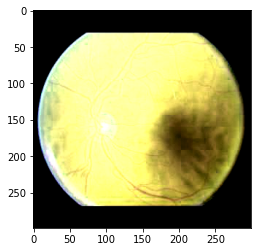

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


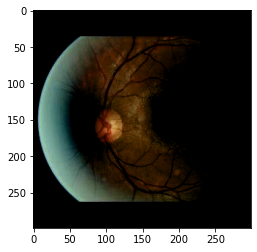

In [7]:

x,y= train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [8]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='sparse'
                                                  )

Found 377 images belonging to 5 classes.


In [9]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(299, 299, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5,activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [10]:
with tf.device('/GPU:0'):
    epochs=200
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size)))
    )

Train for 67 steps, validate for 12 steps
Epoch 1/200
67/67 [==============================] - 27s 401ms/step - loss: 1.4949 - accuracy: 0.3574 - val_loss: 1.4930 - val_accuracy: 0.3554
Epoch 2/200
67/67 [==============================] - 23s 349ms/step - loss: 1.4695 - accuracy: 0.3805 - val_loss: 1.5045 - val_accuracy: 0.3448
Epoch 3/200
67/67 [==============================] - 23s 350ms/step - loss: 1.4714 - accuracy: 0.3875 - val_loss: 1.5025 - val_accuracy: 0.3581
Epoch 4/200
67/67 [==============================] - 23s 347ms/step - loss: 1.4667 - accuracy: 0.4035 - val_loss: 1.4900 - val_accuracy: 0.3581
Epoch 5/200
67/67 [==============================] - 23s 345ms/step - loss: 1.4638 - accuracy: 0.3978 - val_loss: 1.4883 - val_accuracy: 0.3687
Epoch 6/200
67/67 [==============================] - 23s 344ms/step - loss: 1.4588 - accuracy: 0.4129 - val_loss: 1.5091 - val_accuracy: 0.3395
Epoch 7/200
67/67 [==============================] - 23s 345ms/step - loss: 1.4575 - accuracy:

67/67 [==============================] - 24s 356ms/step - loss: 1.3841 - accuracy: 0.5124 - val_loss: 1.5214 - val_accuracy: 0.3634
Epoch 58/200
67/67 [==============================] - 23s 350ms/step - loss: 1.3750 - accuracy: 0.5289 - val_loss: 1.4838 - val_accuracy: 0.4058
Epoch 59/200
67/67 [==============================] - 24s 353ms/step - loss: 1.3860 - accuracy: 0.5110 - val_loss: 1.5034 - val_accuracy: 0.3820
Epoch 60/200
67/67 [==============================] - 23s 349ms/step - loss: 1.3786 - accuracy: 0.5134 - val_loss: 1.5117 - val_accuracy: 0.3687
Epoch 61/200
67/67 [==============================] - 24s 355ms/step - loss: 1.3863 - accuracy: 0.5049 - val_loss: 1.5103 - val_accuracy: 0.3581
Epoch 62/200
67/67 [==============================] - 24s 354ms/step - loss: 1.3790 - accuracy: 0.5186 - val_loss: 1.4674 - val_accuracy: 0.4218
Epoch 63/200
67/67 [==============================] - 24s 352ms/step - loss: 1.3757 - accuracy: 0.5294 - val_loss: 1.4789 - val_accuracy: 0.408

67/67 [==============================] - 25s 373ms/step - loss: 1.3256 - accuracy: 0.5782 - val_loss: 1.4888 - val_accuracy: 0.4005
Epoch 114/200
67/67 [==============================] - 25s 373ms/step - loss: 1.3302 - accuracy: 0.5693 - val_loss: 1.4966 - val_accuracy: 0.4032
Epoch 115/200
67/67 [==============================] - 25s 369ms/step - loss: 1.3248 - accuracy: 0.5726 - val_loss: 1.4850 - val_accuracy: 0.4085
Epoch 116/200
67/67 [==============================] - 25s 373ms/step - loss: 1.3215 - accuracy: 0.5838 - val_loss: 1.5033 - val_accuracy: 0.3952
Epoch 117/200
67/67 [==============================] - 25s 376ms/step - loss: 1.3203 - accuracy: 0.5834 - val_loss: 1.4920 - val_accuracy: 0.3926
Epoch 118/200
67/67 [==============================] - 25s 373ms/step - loss: 1.3210 - accuracy: 0.5801 - val_loss: 1.4816 - val_accuracy: 0.4032
Epoch 119/200
67/67 [==============================] - 25s 369ms/step - loss: 1.3192 - accuracy: 0.5904 - val_loss: 1.4820 - val_accuracy:

67/67 [==============================] - 25s 371ms/step - loss: 1.2816 - accuracy: 0.6233 - val_loss: 1.5131 - val_accuracy: 0.3740
Epoch 170/200
67/67 [==============================] - 25s 372ms/step - loss: 1.2695 - accuracy: 0.6322 - val_loss: 1.5241 - val_accuracy: 0.3714
Epoch 171/200
67/67 [==============================] - 25s 375ms/step - loss: 1.2832 - accuracy: 0.6172 - val_loss: 1.5042 - val_accuracy: 0.3793
Epoch 172/200
67/67 [==============================] - 25s 374ms/step - loss: 1.2890 - accuracy: 0.6120 - val_loss: 1.4949 - val_accuracy: 0.4111
Epoch 173/200
67/67 [==============================] - 25s 370ms/step - loss: 1.2651 - accuracy: 0.6393 - val_loss: 1.5061 - val_accuracy: 0.3873
Epoch 174/200
67/67 [==============================] - 25s 376ms/step - loss: 1.2700 - accuracy: 0.6313 - val_loss: 1.5034 - val_accuracy: 0.3926
Epoch 175/200
67/67 [==============================] - 25s 377ms/step - loss: 1.2670 - accuracy: 0.6355 - val_loss: 1.4934 - val_accuracy:

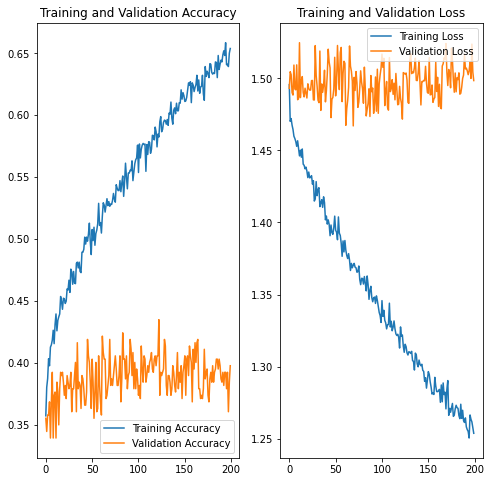

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Guardar el Modelo
model.save('miniprueba2.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')